# Generating Digits with a Diffusion Model

This notebook provides you with a complete code example to generate MNIST digits with a diffusion model.

## Loading the MNIST Dataset with PyTorch

Implement the normalization of the digits ...

In [1]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5], inplace=True),
])

... import the MNIST digits ...

In [2]:
from torchvision.datasets import MNIST

trainset = MNIST(root="data", train=True, transform=transform, download=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 7816837.61it/s] 


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 311117.29it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 2837607.75it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2882076.97it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



... and plot some of the transformed MNIST digits.

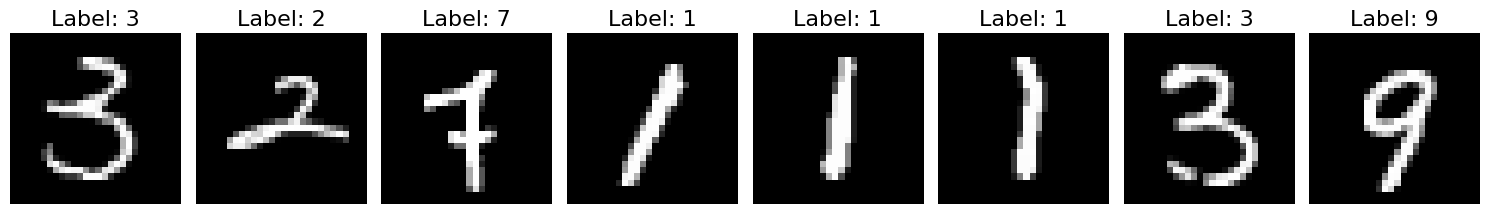

In [4]:
import torch
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 8, figsize=(15, 3))
for ax in axs.ravel():
	img, label = trainset[torch.randint(0, len(trainset), (1,)).squeeze()]
	ax.imshow(img.squeeze(), cmap="gray")
	ax.set_title(f"Label: {label}", fontsize=16)
	ax.axis("off")
plt.tight_layout()
plt.show()

## Implementing the Forward Process

Define the device on which the computations are performed ...

In [5]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(device)

mps


... implement the forward diffusion process ...

In [7]:
class Diffusion:
    """Denoising diffusion probabilstic model (DDPM)."""
    
    def __init__(self, noise_steps=1000, beta_start=1e-4, beta_end=0.02,
                 device=device):
        """Initialize the diffusion model."""
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.device = device

        self.beta = self.prepare_noise_schedule().to(device)
        self.alpha = 1.0 - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)

    def prepare_noise_schedule(self):
        """Prepare the noise schedule."""
        return torch.linspace(self.beta_start, self.beta_end, self.noise_steps)

    def forward_diffusion(self, x, t):
        """Implement the forward diffusion process."""
        sqrt_alpha_bar = torch.sqrt(self.alpha_bar[t])[:, None, None, None]
        sqrt_one_minus_alpha_bar = \
            torch.sqrt(1 - self.alpha_bar[t])[:, None, None, None]
        noise = torch.randn_like(x)

        return sqrt_alpha_bar * x + sqrt_one_minus_alpha_bar * noise, noise

... sampling images in the forward diffusion process ..

In [11]:
diffusion = Diffusion(noise_steps=401, beta_start=0.0001, beta_end=0.02)

clean_image, label = trainset[torch.randint(0, len(trainset), (1,)).squeeze()]

time_steps = [0, 100, 200, 300, 400]

noisy_images = []
for i in range(len(time_steps)):
    noisy_image, noise = diffusion.forward_diffusion(
        x=clean_image[None, ...].to(device), 
        t=torch.tensor([time_steps[i]]).to(device)
    )
    noisy_images.append(noisy_image)

... and visualize the noisy digits generated in the forward diffusion process.

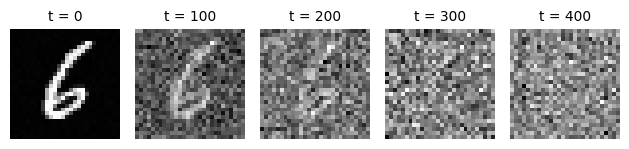

In [12]:
fig, axs = plt.subplots(1, len(time_steps))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(noisy_images[i].cpu().numpy().squeeze(), cmap="gray")
    ax.set_title(f"t = {time_steps[i]}", fontsize=10)
    ax.axis("off")
plt.tight_layout()
plt.show()

## Implementing the Reverse Diffusion Process

Update the `Diffusion` class to implement the reverse diffusion process.

In [13]:
from tqdm import tqdm

class Diffusion:
    """Denoising diffusion probabilstic model (DDPM)."""
    
    def __init__(self, noise_steps=1000, beta_start=1e-4, beta_end=0.02,
                 img_size=28, device=device):
        """Initialize the diffusion model."""
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.img_size = img_size
        self.device = device

        self.beta = self.prepare_noise_schedule().to(device)
        self.alpha = 1.0 - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)

    def prepare_noise_schedule(self):
        """Prepare the noise schedule."""
        return torch.linspace(self.beta_start, self.beta_end, self.noise_steps)

    def forward_diffusion(self, x, t):
        """Implement the forward diffusion process."""
        sqrt_alpha_bar = torch.sqrt(self.alpha_bar[t])[:, None, None, None]
        sqrt_one_minus_alpha_bar = \
            torch.sqrt(1 - self.alpha_bar[t])[:, None, None, None]
        noise = torch.randn_like(x)

        return sqrt_alpha_bar * x + sqrt_one_minus_alpha_bar * noise, noise
    
    def reverse_diffusion(self, model, n_images, n_channels,
                          position_encoding_dim, position_encoding_function,
                          fixed_noise=None, save_time_steps=None):
        """Reverse diffusion process"""
        with torch.no_grad():
            if fixed_noise is not None:
                x = fixed_noise.to(self.device)
            else:
                x = torch.randn(
                    (n_images, n_channels, self.img_size, self.img_size)
                )
                x = x.to(self.device)
            
            denoised_images = []
            for i in tqdm(reversed(range(0, self.noise_steps)),
                          desc="U-Net inference", total=self.noise_steps):
                t = (torch.ones(n_images) * i).long()
                t_pos_enc = position_encoding_function(
                    t.unsqueeze(1), position_encoding_dim
                ).to(self.device)

                predicted_noise = model(x, t_pos_enc)

                alpha = self.alpha[t][:, None, None, None]
                alpha_bar = self.alpha_bar[t][:, None, None, None]
                
                if i > 0:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                    
                x = (1 / torch.sqrt(alpha) * (x - ((1 - alpha) 
                    / torch.sqrt(1 - alpha_bar)) * predicted_noise) 
                    + torch.sqrt(1-alpha) * noise)

                if i in save_time_steps:
                    denoised_images.append(x)

            denoised_images = torch.stack(denoised_images)
            denoised_images = denoised_images.swapaxes(0, 1)
            return denoised_images

## Defining the Position Encoding Function

Implement the position encoding function ...

In [14]:
def positional_encoding(t, enc_dim):
    """Encode position informaiton with a sinusoid."""
    inv_freq = 1.0 / (10000 ** (torch.arange(0, enc_dim, 2).float() 
                                / enc_dim)).to(t.device)
    pos_enc_a = torch.sin(t.repeat(1, enc_dim // 2) * inv_freq)
    pos_enc_b = torch.cos(t.repeat(1, enc_dim // 2) * inv_freq)
    pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
    return pos_enc

... sinusoidal position encodings for different time steps ...

In [16]:
position_encoding_dim = 256

pos_encs = []
for i in range(0, 100):
    t = torch.tensor([i])
    pos_enc = positional_encoding(t, position_encoding_dim)
    pos_encs.append(pos_enc.squeeze())
pos_encs = torch.stack(pos_encs)

... and visualize the position encodings.

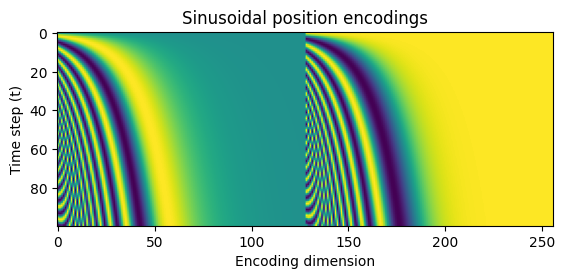

In [17]:
fig = plt.figure()
plt.imshow(pos_encs.cpu().numpy())
plt.xlabel("Encoding dimension")
plt.ylabel("Time step (t)")
plt.title("Sinusoidal position encodings")
plt.show()


## Defining the Attention U-Net

In [19]:
import deeplay as dl

position_encoding_dim = 256

unet = dl.AttentionUNet(
    in_channels=1,
    channels=[32, 64, 128],
    base_channels=[256, 256],
    channel_attention=[True, True, True],
    out_channels=1,
    position_embedding_dim=position_encoding_dim,
)
unet.build()
unet.to(device);

print(unet)

AttentionUNet(
  (encoder): UNetEncoder(
    (conv_block1): DoubleConvBlock(
      (blocks): LayerList(
        (0): Block(
          (layer): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (normalization): GroupNorm(1, 32, eps=1e-05, affine=True)
          (activation): GELU(approximate='none')
        )
        (1): Block(
          (layer): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (normalization): GroupNorm(1, 32, eps=1e-05, affine=True)
          (activation): Identity()
        )
      )
    )
    (blocks): LayerList(
      (0): FeatureIntegrationModule(
        (conv_block): Sequential(
          (0): DoubleConvBlock(
            (blocks): LayerList(
              (0): Block(
                (layer): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                (normalization): GroupNorm(1, 32, eps=1e-05, affine=True)
                (activation): GELU(approximate='none')
              )
          

## Training the Diffusion Model

Define the data loader ...

In [20]:
from torch.utils.data import DataLoader

batch_size = 128
loader = DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True)

... define the loss function ...

In [25]:
criterion = torch.nn.MSELoss()

... define the optimizer ...

In [22]:
optimizer = torch.optim.AdamW(unet.parameters(), lr=1e-4)

...  instantiate the diffusion class for training ...

In [23]:
noise_steps = 1000

diffusion = Diffusion(
    noise_steps=noise_steps,
    img_size=28,
    beta_start=1e-4,
    beta_end=0.02,
)

...implement a function to prepare the data ...

In [24]:
def prepare_data(image, device=device):
    """Prepare data."""
    batch_size = image.shape[0]
    
    t = torch.randint(low=0, high=noise_steps, size=(batch_size,)).to(device)
    image = image.to(device)
    x_t, noise = diffusion.forward_diffusion(image, t)
    t = positional_encoding(t.unsqueeze(1), position_encoding_dim)
    
    return x_t.to(device), t.to(device), noise.to(device)

... implement the training cycle ...


Epoch 1/20
__________
Batch 1/469: Train loss: 0.1257
Batch 101/469: Train loss: 0.0778
Batch 201/469: Train loss: 0.0567
Batch 301/469: Train loss: 0.0573
Batch 401/469: Train loss: 0.0420
----------
Epoch 1/20 : Train loss: 0.0660, Time taken: 0:04:00.259300


U-Net inference: 100%|██████████| 1000/1000 [00:25<00:00, 39.78it/s]


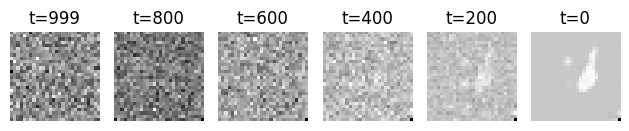


Epoch 2/20
__________
Batch 1/469: Train loss: 0.0471
Batch 101/469: Train loss: 0.0432
Batch 201/469: Train loss: 0.0403
Batch 301/469: Train loss: 0.0424
Batch 401/469: Train loss: 0.0311
----------
Epoch 2/20 : Train loss: 0.0453, Time taken: 0:03:58.302302


U-Net inference: 100%|██████████| 1000/1000 [00:23<00:00, 43.04it/s]


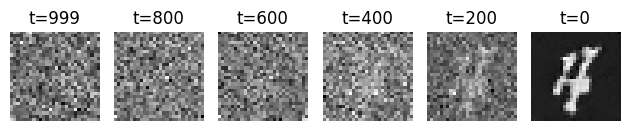


Epoch 3/20
__________
Batch 1/469: Train loss: 0.0455
Batch 101/469: Train loss: 0.0339
Batch 201/469: Train loss: 0.0429
Batch 301/469: Train loss: 0.0399
Batch 401/469: Train loss: 0.0366
----------
Epoch 3/20 : Train loss: 0.0388, Time taken: 0:03:57.627735


U-Net inference: 100%|██████████| 1000/1000 [00:23<00:00, 42.90it/s]


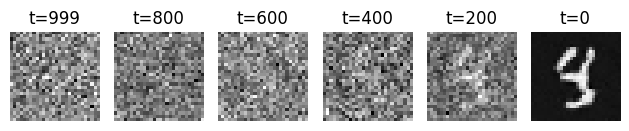


Epoch 4/20
__________
Batch 1/469: Train loss: 0.0362
Batch 101/469: Train loss: 0.0285
Batch 201/469: Train loss: 0.0349


In [27]:
import time
from datetime import timedelta

epochs = 20

train_loss = []
for epoch in range(epochs):
    unet.train()
    
    start_time = time.time()
    num_batches = len(loader)

    print("\n" + f"Epoch {epoch + 1}/{epochs}" + "\n" + "_" * 10)
        
    running_loss = 0.0
    for batch_idx, (images, class_labels) in enumerate(loader, start=0):
        x_t, t, noise = prepare_data(images)
        
        outputs = unet(x_t, t)
        
        optimizer.zero_grad()
        loss = criterion(outputs, noise)
        loss.backward()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print(f"Batch {batch_idx + 1}/{num_batches}: "
                  + f"Train loss: {loss.item():.4f}")
        running_loss += loss.item()

    train_loss.append(running_loss / len(loader))
    end_time = time.time()

    print("-" * 10 + "\n" + f"Epoch {epoch + 1}/{epochs} : " 
          + f"Train loss: {train_loss[-1]:.4f}, " 
          + f"Time taken: {timedelta(seconds=end_time - start_time)}")
    
    unet.eval()
    save_time_steps = [999, 800, 600, 400, 200, 0]
    generated_images = diffusion.reverse_diffusion(
        model=unet,
        n_images=1,
        n_channels=1,
        position_encoding_dim=position_encoding_dim,
        position_encoding_function=positional_encoding,
        save_time_steps=save_time_steps,
    )

    fig, axs = plt.subplots(1, len(save_time_steps))
    for j in range(len(save_time_steps)):
        axs[j].imshow(generated_images[0, j]
            .permute(1, 2, 0).cpu().numpy(), cmap="gray")
        axs[j].set_title(f"t={save_time_steps[j]}")
        axs[j].axis("off")
    plt.tight_layout()
    plt.show()

## Plotting the Training loss

In [ ]:
plt.figure()
plt.plot(train_loss, "g-o", label="Training loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Sampling Images From Fixed Noise

In [ ]:
unet.eval()

fixed_noise = torch.randn((1, 1, 28, 28))
save_time_steps = [999, 800, 600, 400, 200, 0]

for i in range(3):
    generated_images = diffusion.reverse_diffusion(
        model=unet,
        n_images=1,
        n_channels=1,
        fixed_noise=fixed_noise,
        position_encoding_dim=position_encoding_dim,
        position_encoding_function=positional_encoding,
        save_time_steps=save_time_steps,
    )

    fig, axs = plt.subplots(1, len(save_time_steps))
    for j in range(len(save_time_steps)):
        axs[j].imshow(generated_images[0, j]
            .permute(1, 2, 0).cpu().numpy(), cmap="gray")
        axs[j].set_title(f"t={save_time_steps[j]}")
        axs[j].axis("off")
    plt.tight_layout()
    plt.show()

## Similarity Test with Train Dataset

Implement the normalization score function for the similarity test ...

In [ ]:
def normalize_minmax(tensor):
    """Normalize the input tensor to [0, 1] range."""
    min_val = tensor.min(dim=-1, keepdim=True)[0]
    max_val = tensor.max(dim=-1, keepdim=True)[0]
    tensor = (tensor - min_val) / (max_val - min_val)
    return tensor

def compute_l1_score(x, y):
    """Compute the L1 score between two tensors."""
    x = normalize_minmax(x)
    y = normalize_minmax(y)
    differences = torch.abs(x - y)
    loss = differences.sum(dim=-1)
    return loss

... generate images for the similarity test ...

In [ ]:
loader = DataLoader(dataset=trainset, batch_size=100, shuffle=False)
L1_similarities = []

generated_images = diffusion.reverse_diffusion(
    model=unet,
    n_images=100,
    n_channels=1,
    position_encoding_dim=position_encoding_dim,
    position_encoding_function=positional_encoding,
    save_time_steps=[0],
).squeeze()

for batch_idx, (image, class_labels) in enumerate(loader, start=0):
    training_images = image.squeeze().view(-1, 28 * 28)
    training_images = training_images[None, :, :]
    training_images = training_images.to(device)

    generated_images_reshaped = generated_images.view(-1, 28 * 28)
    generated_images_reshaped = generated_images_reshaped[:, None, :]
    
    l1_score = compute_l1_score(
        training_images, generated_images_reshaped)
    L1_similarities.append(l1_score)

L1_similarities = torch.cat(L1_similarities, dim=1)

... plot the similarity scores ...

In [ ]:
plt.figure()
plt.hist(L1_similarities.cpu().numpy().flatten(), bins=100)
plt.title("Histogram of L1 similarities")
plt.xlabel("L1 similarity")
plt.ylabel("Frequency")
plt.show()

...  identify low scoing images ...

In [ ]:
threshold = 50
min_l1_indices = torch.argmin(L1_similarities, dim=1)

low_score_generated_images, low_score_training_images = [], []
for gen_img_idx, train_img_idx in enumerate(min_l1_indices):
    low_l1_score = L1_similarities[gen_img_idx, train_img_idx]
    
    if low_l1_score < threshold:
        low_score_generated_images.append(generated_images[gen_img_idx])
        low_score_training_images.append(trainset[train_img_idx][0])

... and sample low scoring images.

In [ ]:
image_index = torch.randint(0, len(low_score_generated_images), (1,)).item()

plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(low_score_generated_images[image_index]
           .cpu().numpy().squeeze(), cmap="gray")
plt.title("Generated image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(low_score_training_images[image_index].squeeze(), cmap="gray")
plt.title("Closest training image")
plt.axis("off")
plt.show()